# 1. Business Problem: 
 Given an X-ray Image, Generate medical reports from them
# 2. Data Given:
We are given a Bunch of X-ray Images and associated reports with them written by doctors
# 3. Requirements:

Since the model would have a medical application, generating precise and accurate report is required.
Low latency is not required.



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install rouge

In [7]:

import tensorflow as tf
from IPython.display import Image
from IPython.core.display import HTML
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
from tqdm import tqdm
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
# import tensorflow as tf
import xml.etree.ElementTree
import numpy as np
import pandas as pd
import re
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image

import pickle
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nltk.translate.bleu_score as bleu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
np.random.seed(42)
tf.random.set_seed(32)

In [9]:
print(tf.__version__)

2.2.0


In [10]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
image_folder = '/content/drive/My Drive/Colab Notebooks/Medical data case study'
annotation_folder = '/content/drive/My Drive/Colab Notebooks/Medical data case study/ecgen-radiology'


In [12]:
df=pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/x_ray_image_with_report (2).csv")
df.head()


Unnamed: 0  ...                                        image_names
0           0  ...  /content/drive/My Drive/Colab Notebooks/Medica...
1           1  ...  /content/drive/My Drive/Colab Notebooks/Medica...
2           2  ...  /content/drive/My Drive/Colab Notebooks/Medica...
3           3  ...  /content/drive/My Drive/Colab Notebooks/Medica...
4           4  ...  /content/drive/My Drive/Colab Notebooks/Medica...

[5 rows x 5 columns]

In [0]:
all_findings, all_impressions, all_img_names, report_id=df['findings'], df['impressions'],df['image_names'], df['report_id']


In [14]:
all_impressions[0]

'<start> No acute cardiopulmonary abnormality. <end>'

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (512, 624))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [0]:
IMG_SHAPE=(512, 624, 3)

In [17]:
image_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
# Get unique images
# all_findings, all_impressions, all_img_names, report_id

encode_train = sorted(set(all_img_names))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)



In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 5000 words from the vocabulary
top_k = 1225
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",split=' ', char_level=False,
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_impressions)
train_seqs = tokenizer.texts_to_sequences(all_impressions)
# tokenizer.fit_on_texts(df['impressions'])
# train_seqs = tokenizer.texts_to_sequences(df['impressions'])
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [21]:
print(all_impressions[3])
print(tokenizer.index_word[10])
print(tokenizer.word_index['<start>'])
print(tokenizer.index_word[1224])
print(tokenizer.word_index['<start>'])

<start> No acute cardiopulmonary abnormality. <end>
the
2
infrahilar
2


In [0]:
# Create the tokenized vectors
# train_seqs = tokenizer.texts_to_sequences(all_impressions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = 114

In [0]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(all_img_names,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=40)

In [0]:
# Create training and validation sets using an 80-20 split
img_name_test, img_name_val, cap_test, cap_val = train_test_split(img_name_val,
                                                                    cap_val,
                                                                    test_size=0.5,
                                                                    random_state=40)

In [25]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(2672, 2672, 335, 335)

In [26]:
len(img_name_test), len(cap_test)

(334, 334)

In [0]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 32

BUFFER_SIZE = 1000
embedding_dim = 64   #earlier 256
units = 128 #earlier 256
vocab_size = 1225
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 252

In [0]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [0]:
## https://www.tensorflow.org/tutorials/text/image_captioning
## Code taken from official Tensorflow website
np.random.seed(42)
tf.random.set_seed(32)
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc_1 = tf.keras.layers.Dense(3*embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
      

    def call(self, x):
        x = self.fc_1(x)
        x = tf.nn.relu(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        # print("output from CNN encoder : ", x)
        return x 

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units, kernel_initializer='glorot_uniform')
    self.fc2 = tf.keras.layers.Dense(vocab_size, kernel_initializer='glorot_uniform')

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)   

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    # https://www.tensorflow.org/api_docs/python/tf/reshape
    x = tf.reshape(x, (-1, x.shape[2]))
    # print("x in RNN_decode before fc2: ")
    # print(x)
    # print("-"*40)
    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)
    # print("x in RNN_decode after fc2: ")
    # print(x)
    # print("-"*40)
    # print("state in RNN decoder : ",state )
    # print("-"*40)
    # print("attention weights in RNN decoder : ", attention_weights)
    return x, state, attention_weights

  def reset_state(self, batch_size):            
    return tf.zeros((batch_size, self.units))



In [0]:
encoder = CNN_Encoder(embedding_dim) 
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [32]:
len(tokenizer.word_index)

1225

## Training and Validation

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  
  # https://www.tensorflow.org/api_docs/python/tf/expand_dims
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      
      for i in range(1, target.shape[1]):
          
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          
          loss += loss_function(target[:, i], predictions)
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
          
      total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  
  # gradients = tape.gradient(loss, trainable_variables)
  gradients = tape.gradient(total_loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return total_loss, predictions, gradients
  # return loss, total_loss

In [0]:
@tf.function
def val_step(img_tensor, target):
  loss = 0
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  
  features = encoder(img_tensor)

  for i in range(1, target.shape[1]):
    # passing the features through the decoder
    predictions, hidden, _ = decoder(dec_input, features, hidden)
    loss += loss_function(target[:, i], predictions)
    # using teacher forcing
    dec_input = tf.expand_dims(target[:, i], 1)
  total_loss = (loss / int(target.shape[1]))
  return total_loss, predictions


In [35]:
cap_test.shape[1]

114

##  Dataset to batches

In [0]:
#Creating the dataset(only 100 data points and will explain why after trainig process.) 
train_dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

##creating test dataset using tf.data
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
!rm -rf ./checkpoints/
# Clear any logs from previous runs
!rm -rf ./logs/

In [0]:
from datetime import datetime
import time
import math

#tensorboard file writers
#no of data points/batch_size i.e number of iterations in the one epoch
iters = math.ceil(100/BATCH_SIZE) 

# wtrain = tf.summary.create_file_writer(logdir='logs\\train')
# wval = tf.summary.create_file_writer(logdir='logs\\val')
#no of data points/batch_size i.e number of iterations in the one epoch
iters = math.ceil(100/BATCH_SIZE) 

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# Clear any checkpointss from previous runs

# Clear any logs from previous runs

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   # restoring the latest checkpoint in checkpoint_path
#   ckpt.restore(ckpt_manager.latest_checkpoint)


# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset


In [40]:
%tensorboard --logdir logs/gradient_tape

<IPython.core.display.Javascript object>

In [42]:
# optimizer = tf.keras.optimizers.Adam()

epoch_train_loss = tf.keras.metrics.Mean(name='train_loss')
epoch_val_loss = tf.keras.metrics.Mean(name='test_loss')
batch_train_loss = 0
batch_val_loss = 0
EPOCHS=15
for epoch in range(EPOCHS):
  start = time.time()
  #losses
  epoch_train_loss.reset_states()
  epoch_val_loss.reset_states()
  # for img_tensor, target in enumerate(train_dataset):
  for (batch, (img_tensor, target)) in enumerate(train_dataset):
    # print("batch is ", batch)
    # print("image tensor", img_tensor.shape)
    # print("target", target.shape)
  # for img_tensor, target in train_dataset:
    batch_train_loss, gradients, _ = train_step(img_tensor, target)
    epoch_train_loss(batch_train_loss) 
    with train_summary_writer.as_default():
      tf.summary.scalar('batch train loss', batch_train_loss, step=epoch)
    # tf.summary.scalar('batch train loss',batch_train_loss)


  print("total train mean loss is ", epoch_train_loss.result())
  with train_summary_writer.as_default():
    tf.summary.scalar('epoch train loss',epoch_train_loss.result(), step=epoch)
  # for (batch, (img_tensor, target)) in enumerate(val_dataset):
  for img_tensor, target in val_dataset:
    batch_val_loss, t_loss = val_step(img_tensor, target)
    epoch_val_loss(batch_val_loss)
    with train_summary_writer.as_default():
      tf.summary.scalar('batch val loss',batch_val_loss, step=epoch)

  print("total val mean loss is ", epoch_val_loss.result())
  with train_summary_writer.as_default():
    tf.summary.scalar('epoch val loss',epoch_val_loss.result(), step=epoch)
  # if epoch % 5 == 0:
  ckpt_manager.save()
  template = 'Epoch {}, Mean Loss: {}, Mean Val Loss: {}'
  print(template.format(epoch+1, epoch_train_loss.result(), epoch_val_loss.result()))
  print('-'*50)
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start)) 

total train mean loss is  tf.Tensor(0.46528304, shape=(), dtype=float32)
total val mean loss is  tf.Tensor(0.39762524, shape=(), dtype=float32)
Epoch 1, Mean Loss: 0.46528303623199463, Mean Val Loss: 0.39762523770332336
--------------------------------------------------
Time taken for 1 epoch 354.2062118053436 sec

total train mean loss is  tf.Tensor(0.3542198, shape=(), dtype=float32)
total val mean loss is  tf.Tensor(0.38173172, shape=(), dtype=float32)
Epoch 2, Mean Loss: 0.35421979427337646, Mean Val Loss: 0.38173171877861023
--------------------------------------------------
Time taken for 1 epoch 101.5059802532196 sec

total train mean loss is  tf.Tensor(0.35188928, shape=(), dtype=float32)
total val mean loss is  tf.Tensor(0.38056123, shape=(), dtype=float32)
Epoch 3, Mean Loss: 0.3518892824649811, Mean Val Loss: 0.3805612325668335
--------------------------------------------------
Time taken for 1 epoch 22.109628200531006 sec

total train mean loss is  tf.Tensor(0.34822366, sha

In [0]:
def evaluate_x(image):
  attention_plot = np.zeros((max_length, 252))
  hidden = decoder.reset_state(batch_size=1)
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  features = encoder(img_tensor_val)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) # Start token is <start> for LSTM
  result = []
  for i in range(max_length): 
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result.append(tokenizer.index_word[predicted_id]) # Store the result or word predicted
    if tokenizer.index_word[predicted_id] == '<end>': # if you reach <end> token then return the result
        return result, attention_plot
    dec_input = tf.expand_dims([predicted_id], 0) # Decoder input is the word predicted at previous timestep
  attention_plot = attention_plot[:len(result), :]
  return result, attention_plot

def evaluate(image):
  attention_plot = np.zeros((max_length, 252))
  hidden = decoder.reset_state(batch_size=1)
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  features = encoder(img_tensor_val)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []
  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
    result.append(tokenizer.index_word[predicted_id])
    if tokenizer.index_word[predicted_id] == '<end>':
      return result, attention_plot   
    dec_input = tf.expand_dims([predicted_id], 0)
  attention_plot = attention_plot[:len(result), :]
  return result, attention_plot

def evaluate_beam(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]    
    # result[0][0] = index of the starting word
    # result[0][1] = probability of the word predicted
    result = [[start, 0.0]]
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0                                
        temp = []
        for s in result:

          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

          attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
          i=i+1
          # Getting the top <beam_index>(n) predictions
          # word_preds = np.argsort(predictions[0])[-beam_index:]   
          word_preds = tf.random.categorical(predictions, 1)[0][-beam_index:].numpy()              
          
          # creating a new list so as to put them via the model again
          for w in word_preds:       
            next_cap, prob = s[0][:], s[1]
            next_cap.append(w)
            prob += predictions[0][w]
            temp.append([next_cap, prob])
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]   
        
        predicted_id = result[-1] # with Max Probability
        pred_list = predicted_id[0]        
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
          dec_input = tf.expand_dims([prd_id], 0)  # Decoder input is the word predicted with highest probability among the top_k words predicted
        else:
          break

    result = result[-1][0]    
    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    for i in intermediate_caption:
        if i == '<end>':
          final_caption.append(" <end>")
          break
        if i != '<end>':
          final_caption.append(i)
            
        # else:
        #     break
    
    # final_caption = ' '.join(final_caption[1:])
    # final_caption=final_caption + ' <end>'
    # print("shape beam", attention_plot.shape)
    return final_caption[1:],attention_plot       


def evaluate_image(image):
  attention_plot = np.zeros((max_length, 252))
  hidden = decoder.reset_state(batch_size=1)
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  features = encoder(img_tensor_val)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []
  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
    result.append(tokenizer.index_word[predicted_id])
    if tokenizer.index_word[predicted_id] == '<end>':
      result=" ".join(result)
      return result 
    dec_input = tf.expand_dims([predicted_id], 0)
  # attention_plot = attention_plot[:len(result), :]
  result=" ".join(result)
  return result
import PIL.Image     
def plot_attention(image, result, attention_plot):
    # img_name_to_save=image
    temp_image = np.array(PIL.Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)    
    for l in range(len_result):
        # print("shape attention plot[l]= ", attention_plot.shape)
        temp_att = np.resize(attention_plot[l], (8, 8))          
        ax = fig.add_subplot((len_result//2)+1, (len_result//2)+1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    plt.tight_layout()
    plt.savefig("{}.png".format(image)) # save as png
    plt.show()                                                                  

In [73]:
img=img_name_test[1891]
evaluate_image(img)

'negative of elevated and prominent heart left underlying l2 lungs <end>'

In [76]:
import nltk
from rouge import Rouge 

hypothesis = "the #### transcript is a written version of each day 's cnn student news program use this transcript to he    lp students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of storie s you     saw on cnn student news"

reference = "this page includes the show transcript use the transcript to help students with reading comprehension and     vocabulary at the bottom of the page , comment for a chance to be mentioned on cnn student news . you must be a teac    her or a student age # # or older to request a mention on the cnn student news roll call . the weekly newsquiz tests     students ' knowledge of even ts in the news"
# hypothesis = ['It', 'is', 'a', 'cat', 'at', 'room']
# reference = ['It', 'is', 'a', 'cat', 'inside', 'the', 'room']
rouge = Rouge()
scores = rouge.get_scores(reference, hypothesis)
print("Rouge ",scores)
print("-"*40)
BLEUscore = nltk.translate.bleu_score.sentence_bleu(reference, hypothesis)
print("BLEU ",BLEUscore)

Rouge  [{'rouge-1': {'f': 0.4786324739396596, 'p': 0.3835616438356164, 'r': 0.6363636363636364}, 'rouge-2': {'f': 0.2608695605353498, 'p': 0.20833333333333334, 'r': 0.3488372093023256}, 'rouge-l': {'f': 0.44705881864636676, 'p': 0.3877551020408163, 'r': 0.5277777777777778}}]
----------------------------------------
BLEU  0.5709952716100181


In [0]:
def evaluate_juggad(xx):                   
  # xx=str(xx).split(" ")
  # xx=xx[0]
  # image=img_name_test[int(xx)]
  a=df[df['image_names']==xx]           
  real_caption=a['impressions']
  return xx, real_caption

In [0]:
predictions_train_1=[]
real_caption_train=[]
for i in img_name_train:
  image, real_caption=evaluate_juggad(i)
  predictions_train_1.append(evaluate_image(image))
  real_caption_train.append(real_caption) 

predictions_train_2=[]
for i in img_name_train:
  image, real_caption=evaluate_juggad(i)
  predictions_train_2.append(evaluate_image(image))
  # real_caption_test.append(real_caption.to_list())

predictions_train_3=[]
for i in img_name_train:
  image, real_caption=evaluate_juggad(i)
  predictions_train_3.append(evaluate_image(image))
  # real_caption_test.append(real_caption.to_list())

In [0]:
predictions_test_1=[]
real_caption_test=[]
for i in img_name_test:
  image, real_caption=evaluate_juggad(i)
  predictions_test_1.append(evaluate_image(image))
  real_caption_test.append(real_caption)

predictions_test_2=[]
for i in img_name_test:
  image, real_caption=evaluate_juggad(i)
  predictions_test_2.append(evaluate_image(image))         
  # real_caption_test.append(real_caption.to_list())

predictions_test_3=[]
for i in img_name_test:           
  image, real_caption=evaluate_juggad(i)
  predictions_test_3.append(evaluate_image(image))
  # real_caption_test.append(real_caption.to_list())

In [0]:
predictions_val_1=[]
real_caption_val=[]
for i in img_name_val:
  image, real_caption=evaluate_juggad(i)
  predictions_val_1.append(evaluate_image(image))
  real_caption_val.append(real_caption)

predictions_val_2=[]
for i in img_name_val:
  image, real_caption=evaluate_juggad(i)
  predictions_val_2.append(evaluate_image(image))
  # real_caption_test.append(real_caption.to_list())

predictions_val_3=[]
for i in img_name_val:
  image, real_caption=evaluate_juggad(i)
  predictions_val_3.append(evaluate_image(image))
  # real_caption_test.append(real_caption.to_list())

In [82]:
print(real_caption_val[0], "-"*10, predictions_val_1[0])      
print(real_caption_val[0], "-"*10, predictions_val_2[0])      
print(real_caption_val[0], "-"*10, predictions_val_3[0])      

1282    <start> No acute cardiopulmonary findings. <end>
Name: impressions, dtype: object ---------- thoracotomy base pneumonitis active of basilar left left shoulder evaluation <end>
1282    <start> No acute cardiopulmonary findings. <end>
Name: impressions, dtype: object ---------- borderline significance <end>
1282    <start> No acute cardiopulmonary findings. <end>
Name: impressions, dtype: object ---------- no acute disease acute cardiopulmonary disease <end>


In [0]:
scores = rouge.get_scores(real_caption_val[0].to_string(),predictions_val_1[0][0] )

In [84]:
predictions_val_1[0]

'thoracotomy base pneumonitis active of basilar left left shoulder evaluation <end>'

In [85]:
scores[0]['rouge-l']['f']

0.0

In [0]:
rouge_train_1=[]
rouge_train_2=[]
rouge_train_3=[]
for i in range(len(img_name_train)):
  scores=rouge.get_scores(real_caption_train[i].to_string(),predictions_train_1[i] )
  rouge_train_1.append(scores[0]['rouge-l']['f'])
  scores=rouge.get_scores(real_caption_train[i].to_string(),predictions_train_2[i] )
  rouge_train_2.append(scores[0]['rouge-l']['f'])
  scores=rouge.get_scores(real_caption_train[i].to_string(),predictions_train_3[i] )
  rouge_train_3.append(scores[0]['rouge-l']['f'])

rouge_val_1=[]
rouge_val_2=[]
rouge_val_3=[]
for i in range(len(img_name_val)):
  scores=rouge.get_scores(real_caption_val[i].to_string(),predictions_val_1[i] )
  rouge_val_1.append(scores[0]['rouge-l']['f'])
  scores=rouge.get_scores(real_caption_val[i].to_string(),predictions_val_2[i] )
  rouge_val_2.append(scores[0]['rouge-l']['f'])
  scores=rouge.get_scores(real_caption_val[i].to_string(),predictions_val_3[i] )
  rouge_val_3.append(scores[0]['rouge-l']['f'])

rouge_test_1=[]
rouge_test_2=[]
rouge_test_3=[]
for i in range(len(img_name_test)):
  scores=rouge.get_scores(real_caption_test[i].to_string(),predictions_test_1[i] )
  rouge_test_1.append(scores[0]['rouge-l']['f'])
  scores=rouge.get_scores(real_caption_test[i].to_string(),predictions_test_2[i] )
  rouge_test_2.append(scores[0]['rouge-l']['f'])
  scores=rouge.get_scores(real_caption_test[i].to_string(),predictions_test_3[i] )
  rouge_test_3.append(scores[0]['rouge-l']['f'])

In [87]:
np.mean(rouge_train_1),np.mean(rouge_train_2),np.mean(rouge_train_3)

(0.16570296973747686, 0.1651412819392868, 0.17096447900974893)

In [88]:
np.mean(rouge_val_1),np.mean(rouge_val_2),np.mean(rouge_val_3)

(0.1667904965086702, 0.15727371831564393, 0.15823245024706983)

In [89]:
np.mean(rouge_test_1),np.mean(rouge_test_2),np.mean(rouge_test_3)

(0.16081941810120448, 0.16661392836371222, 0.15869077126198192)

In [0]:
bleu_train_1_gram_first=[]
bleu_train_1_gram_second=[]
bleu_train_1_gram_third=[]
bleu_train_1_gram=[]
for i in range(len(real_caption_train)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_1[i], weights=(1, 0, 0, 0))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_2[i], weights=(1, 0, 0, 0))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_3[i], weights=(1, 0, 0, 0))
  bleu_train_1_gram.append(max(score1, score2, score3))  
  bleu_train_1_gram_first.append(score1)
  bleu_train_1_gram_second.append(score2)
  bleu_train_1_gram_third.append(score3)  

bleu_train_2_gram_first=[]
bleu_train_2_gram_second=[]
bleu_train_2_gram_third=[]
bleu_train_2_gram=[]
for i in range(len(real_caption_train)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_1[i], weights=(0, 1, 0, 0))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_2[i], weights=(0, 1, 0, 0))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_3[i], weights=(0, 1, 0, 0))
  bleu_train_2_gram.append(max(score1, score2, score3))    
  bleu_train_2_gram_first.append(score1)
  bleu_train_2_gram_second.append(score2)
  bleu_train_2_gram_third.append(score3)


bleu_train_3_gram_first=[]
bleu_train_3_gram_second=[]
bleu_train_3_gram_third=[]
bleu_train_3_gram=[]
for i in range(len(real_caption_train)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_1[i], weights=(0, 0, 1, 0))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_2[i], weights=(0, 0, 1, 0))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_3[i], weights=(0, 0, 1, 0))
  bleu_train_3_gram.append(max(score1, score2, score3)) 
  bleu_train_3_gram_first.append(score1) 
  bleu_train_3_gram_second.append(score2)  
  bleu_train_3_gram_third.append(score3)   

bleu_train_4_gram_first=[]
bleu_train_4_gram_second=[]
bleu_train_4_gram_third=[]
bleu_train_4_gram=[]
for i in range(len(real_caption_train)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_1[i], weights=(0, 0, 0, 1))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_2[i], weights=(0, 0, 0, 1))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_train[i], predictions_train_3[i], weights=(0, 0, 0, 1))
  bleu_train_4_gram.append(max(score1, score2, score3))
  bleu_train_4_gram_first.append(score1) 
  bleu_train_4_gram_second.append(score2)
  bleu_train_4_gram_third.append(score3)   

In [91]:
print("Mean 1st predictions : ",np.mean(bleu_train_1_gram_first), np.mean(bleu_train_2_gram_first), np.mean(bleu_train_3_gram_first), np.mean(bleu_train_4_gram_first))
print("Mean 2nd predictions : ",np.mean(bleu_train_1_gram_second), np.mean(bleu_train_2_gram_second), np.mean(bleu_train_3_gram_second), np.mean(bleu_train_4_gram_second))
print("Mean 3rd predictions : ",np.mean(bleu_train_1_gram_third), np.mean(bleu_train_2_gram_third), np.mean(bleu_train_3_gram_third), np.mean(bleu_train_4_gram_third))
print("Median 1st predictions : ",np.median(bleu_train_1_gram_first), np.median(bleu_train_2_gram_first), np.median(bleu_train_3_gram_first), np.median(bleu_train_4_gram_first))
print("Median 2nd predictions : ",np.median(bleu_train_1_gram_second), np.median(bleu_train_2_gram_second), np.median(bleu_train_3_gram_second), np.median(bleu_train_4_gram_second))
print("Median 3rd predictions : ",np.median(bleu_train_1_gram_third), np.median(bleu_train_2_gram_third), np.median(bleu_train_3_gram_third), np.median(bleu_train_4_gram_third))

Mean 1st predictions :  0.3901427298551016 0.23207829007475608 0.1664225626236481 0.13919995058514276
Mean 2nd predictions :  0.39488557241059435 0.23263814908666205 0.16563050840932916 0.1378073937494105
Mean 3rd predictions :  0.39489788942641374 0.2360205886974578 0.16947757165488697 0.14173115198412448
Median 1st predictions :  0.41169547150403646 0.21494760646448258 0.12133835581008798 0.08791208791208792
Median 2nd predictions :  0.41567946695023383 0.21052631578947367 0.12118247419434941 0.08601738103575678
Median 3rd predictions :  0.4173471356008487 0.21292161591506764 0.12498780040911485 0.0909090909090909


In [92]:
print("Max 1st predictions : ",np.mean(bleu_train_1_gram), np.mean(bleu_train_2_gram), np.mean(bleu_train_3_gram), np.mean(bleu_train_4_gram))

Max 1st predictions :  0.5703997678430721 0.356770929392887 0.27231650037879696 0.23491995861212045


In [0]:
bleu_val_1_gram_first=[]
bleu_val_1_gram_second=[]
bleu_val_1_gram_third=[]
bleu_val_1_gram=[]
for i in range(len(real_caption_val)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_1[i], weights=(1, 0, 0, 0))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_2[i], weights=(1, 0, 0, 0))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_3[i], weights=(1, 0, 0, 0))
  bleu_val_1_gram.append(max(score1, score2, score3))  
  bleu_val_1_gram_first.append(score1)
  bleu_val_1_gram_second.append(score2)
  bleu_val_1_gram_third.append(score3)  

bleu_val_2_gram_first=[]
bleu_val_2_gram_second=[]
bleu_val_2_gram_third=[]
bleu_val_2_gram=[]
for i in range(len(real_caption_val)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_1[i], weights=(0, 1, 0, 0))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_2[i], weights=(0, 1, 0, 0))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_3[i], weights=(0, 1, 0, 0))
  bleu_val_2_gram.append(max(score1, score2, score3))    
  bleu_val_2_gram_first.append(score1)
  bleu_val_2_gram_second.append(score2)
  bleu_val_2_gram_third.append(score3)


bleu_val_3_gram_first=[]
bleu_val_3_gram_second=[]
bleu_val_3_gram_third=[]
bleu_val_3_gram=[]
for i in range(len(real_caption_val)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_1[i], weights=(0, 0, 1, 0))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_2[i], weights=(0, 0, 1, 0))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_3[i], weights=(0, 0, 1, 0))
  bleu_val_3_gram.append(max(score1, score2, score3)) 
  bleu_val_3_gram_first.append(score1) 
  bleu_val_3_gram_second.append(score2)  
  bleu_val_3_gram_third.append(score3)   

bleu_val_4_gram_first=[]
bleu_val_4_gram_second=[]
bleu_val_4_gram_third=[]
bleu_val_4_gram=[]
for i in range(len(real_caption_val)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_1[i], weights=(0, 0, 0, 1))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_2[i], weights=(0, 0, 0, 1))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_val[i], predictions_val_3[i], weights=(0, 0, 0, 1))
  bleu_val_4_gram.append(max(score1, score2, score3))
  bleu_val_4_gram_first.append(score1) 
  bleu_val_4_gram_second.append(score2)
  bleu_val_4_gram_third.append(score3)   

In [94]:
print("Mean 1st predictions : ",np.mean(bleu_val_1_gram_first), np.mean(bleu_val_2_gram_first), np.mean(bleu_val_3_gram_first), np.mean(bleu_val_4_gram_first))
print("Mean 2nd predictions : ",np.mean(bleu_val_1_gram_second), np.mean(bleu_val_2_gram_second), np.mean(bleu_val_3_gram_second), np.mean(bleu_val_4_gram_second))
print("Mean 3rd predictions : ",np.mean(bleu_val_1_gram_third), np.mean(bleu_val_2_gram_third), np.mean(bleu_val_3_gram_third), np.mean(bleu_val_4_gram_third))
print("Median 1st predictions : ",np.median(bleu_val_1_gram_first), np.median(bleu_val_2_gram_first), np.median(bleu_val_3_gram_first), np.median(bleu_val_4_gram_first))
print("Median 2nd predictions : ",np.median(bleu_val_1_gram_second), np.median(bleu_val_2_gram_second), np.median(bleu_val_3_gram_second), np.median(bleu_val_4_gram_second))
print("Median 3rd predictions : ",np.median(bleu_val_1_gram_third), np.median(bleu_val_2_gram_third), np.median(bleu_val_3_gram_third), np.median(bleu_val_4_gram_third))

Mean 1st predictions :  0.3811076899864119 0.22661838074858953 0.16099249055856943 0.1346323308755079
Mean 2nd predictions :  0.37121360482061444 0.21380675206241972 0.15096380512374663 0.1257990118766743
Mean 3rd predictions :  0.37569639273302646 0.22169083628808797 0.1569713683025035 0.13041849356866395
Median 1st predictions :  0.41509433962264153 0.20833251658255228 0.12365197738787298 0.08888888888888888
Median 2nd predictions :  0.3828548533632722 0.1935483870967742 0.10309278350515462 0.06944209156563658
Median 3rd predictions :  0.3821365668038188 0.20221666179552242 0.10869565217391305 0.07368421052631577


In [95]:
print("Max 1st predictions mean : ",np.mean(bleu_val_1_gram), np.mean(bleu_val_2_gram), np.mean(bleu_val_3_gram), np.mean(bleu_val_4_gram))

Max 1st predictions mean :  0.5548897436638394 0.34074564839382887 0.25677252093592096 0.2205492374637556


In [96]:
print("Max 1st predictions median : ",np.median(bleu_val_1_gram), np.median(bleu_val_2_gram), np.median(bleu_val_3_gram), np.median(bleu_val_4_gram))

Max 1st predictions median :  0.6127777630167346 0.32575757575757575 0.22101103303377706 0.17567567567567569


In [0]:
bleu_test_1_gram_first=[]
bleu_test_1_gram_second=[]
bleu_test_1_gram_third=[]
bleu_test_1_gram=[]
for i in range(len(real_caption_test)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_1[i], weights=(1, 0, 0, 0))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_2[i], weights=(1, 0, 0, 0))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_3[i], weights=(1, 0, 0, 0))
  bleu_test_1_gram.append(max(score1, score2, score3))  
  bleu_test_1_gram_first.append(score1)
  bleu_test_1_gram_second.append(score2)
  bleu_test_1_gram_third.append(score3)  

bleu_test_2_gram_first=[]
bleu_test_2_gram_second=[]
bleu_test_2_gram_third=[]
bleu_test_2_gram=[]
for i in range(len(real_caption_test)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_1[i], weights=(0, 1, 0, 0))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_2[i], weights=(0, 1, 0, 0))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_3[i], weights=(0, 1, 0, 0))
  bleu_test_2_gram.append(max(score1, score2, score3))    
  bleu_test_2_gram_first.append(score1)
  bleu_test_2_gram_second.append(score2)
  bleu_test_2_gram_third.append(score3)


bleu_test_3_gram_first=[]
bleu_test_3_gram_second=[]
bleu_test_3_gram_third=[]
bleu_test_3_gram=[]
for i in range(len(real_caption_test)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_1[i], weights=(0, 0, 1, 0))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_2[i], weights=(0, 0, 1, 0))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_3[i], weights=(0, 0, 1, 0))
  bleu_test_3_gram.append(max(score1, score2, score3)) 
  bleu_test_3_gram_first.append(score1) 
  bleu_test_3_gram_second.append(score2)  
  bleu_test_3_gram_third.append(score3)   

bleu_test_4_gram_first=[]
bleu_test_4_gram_second=[]
bleu_test_4_gram_third=[]
bleu_test_4_gram=[]
for i in range(len(real_caption_test)):
  score1=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_1[i], weights=(0, 0, 0, 1))
  score2=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_2[i], weights=(0, 0, 0, 1))
  score3=nltk.translate.bleu_score.sentence_bleu(real_caption_test[i], predictions_test_3[i], weights=(0, 0, 0, 1))
  bleu_test_4_gram.append(max(score1, score2, score3))
  bleu_test_4_gram_first.append(score1) 
  bleu_test_4_gram_second.append(score2)
  bleu_test_4_gram_third.append(score3)   

In [98]:
print("Mean 1st predictions : ",np.mean(bleu_test_1_gram_first), np.mean(bleu_test_2_gram_first), np.mean(bleu_test_3_gram_first), np.mean(bleu_test_4_gram_first))
print("Mean 2nd predictions : ",np.mean(bleu_test_1_gram_second), np.mean(bleu_test_2_gram_second), np.mean(bleu_test_3_gram_second), np.mean(bleu_test_4_gram_second))
print("Mean 3rd predictions : ",np.mean(bleu_test_1_gram_third), np.mean(bleu_test_2_gram_third), np.mean(bleu_test_3_gram_third), np.mean(bleu_test_4_gram_third))
print("Median 1st predictions : ",np.median(bleu_test_1_gram_first), np.median(bleu_test_2_gram_first), np.median(bleu_test_3_gram_first), np.median(bleu_test_4_gram_first))
print("Median 2nd predictions : ",np.median(bleu_test_1_gram_second), np.median(bleu_test_2_gram_second), np.median(bleu_test_3_gram_second), np.median(bleu_test_4_gram_second))
print("Median 3rd predictions : ",np.median(bleu_test_1_gram_third), np.median(bleu_test_2_gram_third), np.median(bleu_test_3_gram_third), np.median(bleu_test_4_gram_third))

Mean 1st predictions :  0.38516345139461106 0.2253623560448934 0.16107679831242291 0.1348543678846211
Mean 2nd predictions :  0.3846465348972344 0.22765234433809872 0.1640125127861311 0.13674036922668914
Mean 3rd predictions :  0.3680349882628957 0.2130737494597551 0.14817467550292807 0.12232763134653826
Median 1st predictions :  0.3998753883218161 0.20210698134321115 0.11208607708139268 0.08086312118570183
Median 2nd predictions :  0.40984768040815245 0.21266320695138863 0.12165478459432577 0.0844950496124231
Median 3rd predictions :  0.3816077343301026 0.1953342855199619 0.11111484275043493 0.07303659616492392


In [99]:
print(np.mean(bleu_test_1_gram), np.mean(bleu_test_2_gram), np.mean(bleu_test_3_gram), np.mean(bleu_test_4_gram))

0.5647284740083665 0.3455721437808365 0.2604289721177381 0.2237256899922109


In [100]:
print(np.mean(bleu_test_1_gram), np.mean(bleu_test_2_gram), np.mean(bleu_test_3_gram), np.mean(bleu_test_4_gram))

0.5647284740083665 0.3455721437808365 0.2604289721177381 0.2237256899922109


In [102]:
import shutil
src='/content/checkpoints'
dst='/content/drive/My Drive/Colab Notebooks/checkpoints_2'

shutil.copytree(src, dst)

'/content/drive/My Drive/Colab Notebooks/checkpoints_2'

# Error Analysis

In [0]:
## To display long captions
pd.set_option('display.max_colwidth', -1)
## https://stackoverflow.com/questions/29902714/print-very-long-string-completely-in-pandas-dataframe

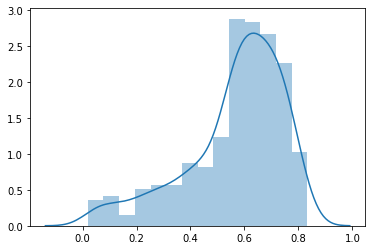

In [104]:

sns.distplot(bleu_test_1_gram)
plt.plot()
plt.savefig('bleu_test_1_gram.png', dpi=400)

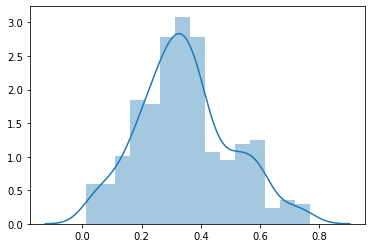

In [105]:
sns.distplot(bleu_test_2_gram)
plt.plot()
plt.savefig('bleu_test_2_gram.png', dpi=400)

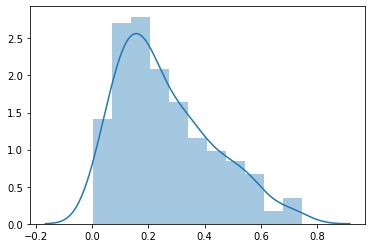

In [106]:
sns.distplot(bleu_test_3_gram)
plt.plot()
plt.savefig('bleu_test_3_gram.png', dpi=400) 

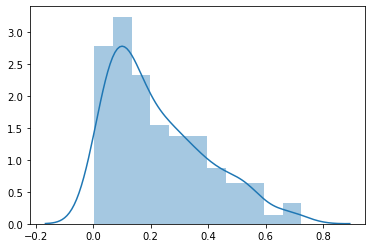

In [107]:
sns.distplot(bleu_test_4_gram)
plt.plot()
plt.savefig('bleu_test_4_gram.png', dpi=400)

In [0]:
test_error_good=[]
for i in bleu_test_1_gram:
  if i>0.4:
    test_error_good.append(bleu_test_1_gram.index(i))

In [109]:
print(len(test_error_good))
print('indices to analyse: ', test_error_good)

278
indices to analyse:  [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 14, 49, 50, 52, 53, 55, 56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 95, 96, 97, 30, 99, 101, 103, 104, 105, 106, 107, 109, 110, 30, 112, 32, 90, 115, 116, 117, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 131, 132, 133, 134, 135, 137, 139, 141, 142, 144, 145, 146, 132, 148, 150, 151, 152, 153, 154, 155, 157, 158, 27, 160, 161, 162, 11, 164, 166, 167, 91, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 132, 188, 189, 191, 91, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 122, 211, 212, 199, 215, 216, 217, 146, 220, 221, 222, 224, 225, 228, 229, 230, 221, 232, 233, 234, 235, 236, 237, 181, 239, 240, 241, 14, 58, 244, 245, 246, 247, 248, 249, 250, 252, 253, 254, 2

In [0]:
test_error_bad=[]
for i in bleu_test_1_gram:
  if i<0.2:
    test_error_bad.append(bleu_test_1_gram.index(i))

In [111]:
print(len(test_error_bad))
print('indices to analyse: ', test_error_bad)

22
indices to analyse:  [0, 34, 94, 100, 102, 130, 140, 165, 169, 170, 182, 201, 251, 264, 267, 268, 270, 274, 276, 280, 298, 313]


## Perfect Captions

Real Caption: 827    <start> No active disease. <end>
Prediction Caption: no acute disease  <end>


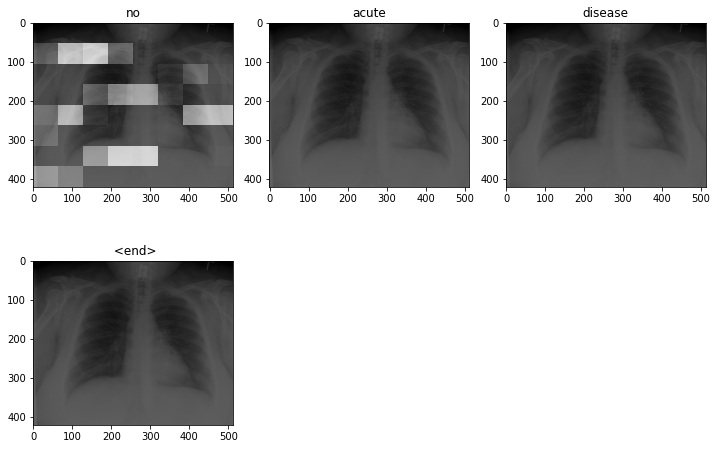

In [0]:
# captions on the validation set
image=img_name_test[827]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
real_caption=real_caption.to_string()
result, attention_plot = evaluate_beam(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# plt.savefig('rename_image.png')

Real Caption: 2367    <start> No active disease. <end>
Name: impressions, dtype: object
Prediction Caption: no acute cardiopulmonary abnormality <end>


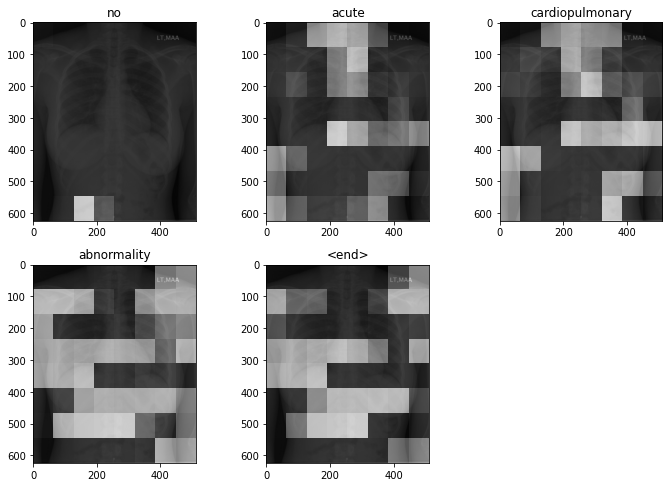

In [0]:
# captions on the validation set
image=img_name_test[2367]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: 964    <start> Negative chest x-. <end>
Name: impressions, dtype: object
Prediction Caption: no acute findings cardiopulmonary disease  <end>


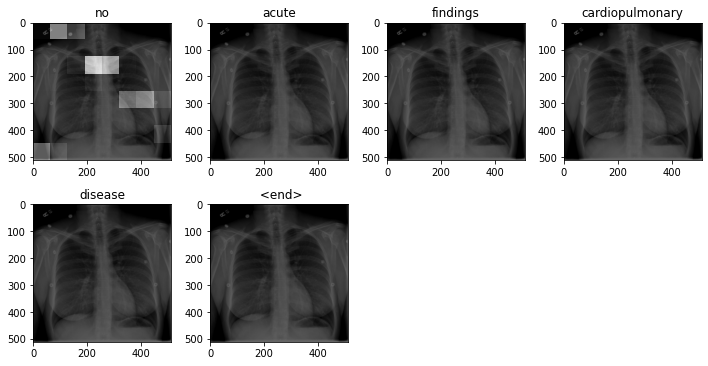

In [0]:
# captions on the validation set
image=img_name_test[964]                  
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]                                                      
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate_beam(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


In [0]:
img_name_test[10:13]

396     /content/drive/My Drive/Colab Notebooks/Medical data case study/CXR514_IM-2129-1001.png 
2367    /content/drive/My Drive/Colab Notebooks/Medical data case study/CXR2621_IM-1109-1001.png
1891    /content/drive/My Drive/Colab Notebooks/Medical data case study/CXR2093_IM-0723-1001.png
Name: image_names, dtype: object

Real Caption: 1891    <start> No focal lung infiltrates. <end>
Name: impressions, dtype: object
Prediction Caption: no acute cardiopulmonary abnormality <end>
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)


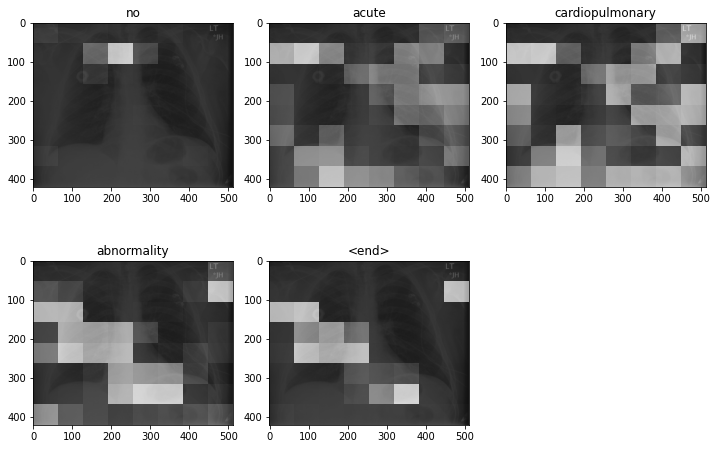

In [0]:
# captions on the validation set
image=img_name_test[1891]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: 396    <start> No acute cardiopulmonary findings. <end>
Name: impressions, dtype: object
Prediction Caption: no acute cardiopulmonary abnormality <end>
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)


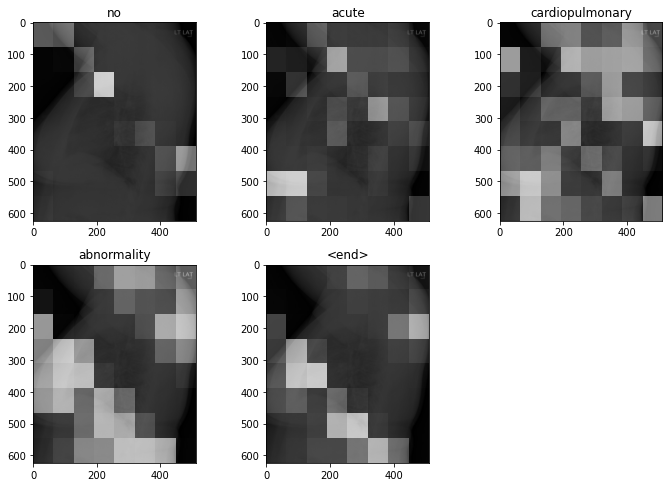

In [0]:
# captions on the validation set
image=img_name_test[396]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: 2367    <start> No active disease. <end>
Name: impressions, dtype: object
Prediction Caption: no acute cardiopulmonary abnormality <end>
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)


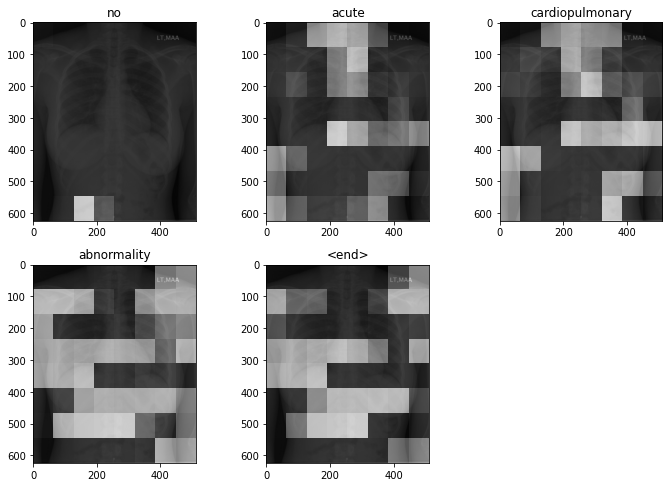

In [0]:
# captions on the validation set
image=img_name_test[2367]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Okayish report

Real Caption: 1119    <start> Right mid lung mass with mild right pa...
Name: impressions, dtype: object
Prediction Caption: no acute cardiopulmonary abnormality <end>
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)


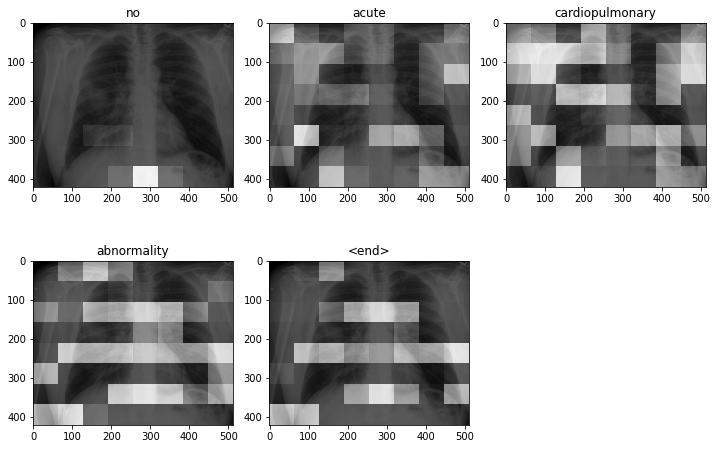

In [0]:
# captions on the validation set
image=img_name_test[1119]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: 3148    <start>  Negative for acute cardiopulmonary disease.  .4 cm right lower lobe nodule,  calcified granulomas disease. If patient high  for pulmonary malignancy, consider cross-sectional imaging to verify. <end>
Name: impressions, dtype: object
Prediction Caption: no acute findings <end>


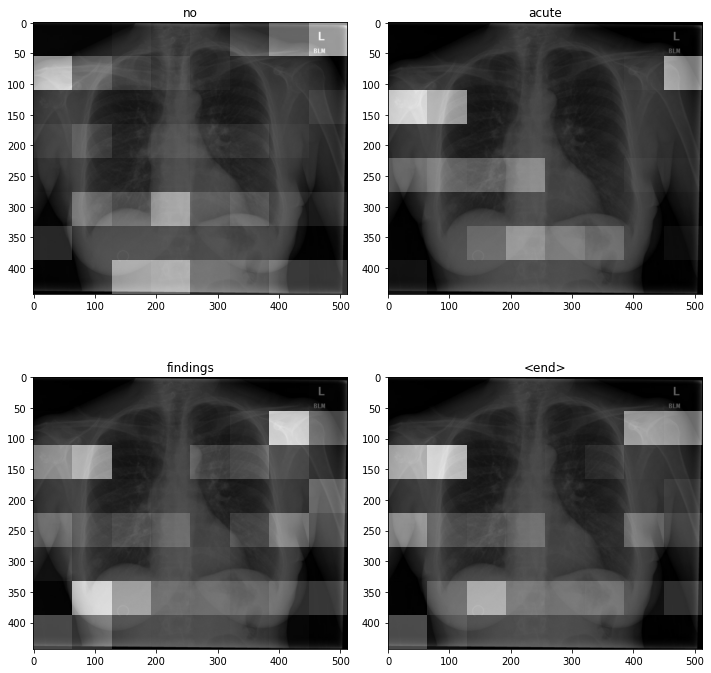

In [0]:
# captions on the validation set
image=img_name_test[3148]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: 3248    <start> Changes of chronic interstitial lung d...
Name: impressions, dtype: object
Prediction Caption: no acute cardiopulmonary abnormality <end>


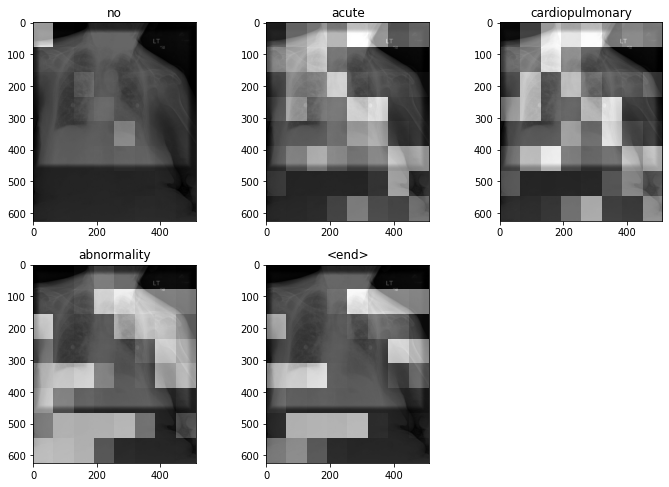

In [0]:
# captions on the validation set
image=img_name_test[3248]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: 646    <start> There is no radiographic evidence of acute cardiopulmonary disease. <end>
Name: impressions, dtype: object
Prediction Caption: no acute findings <end>


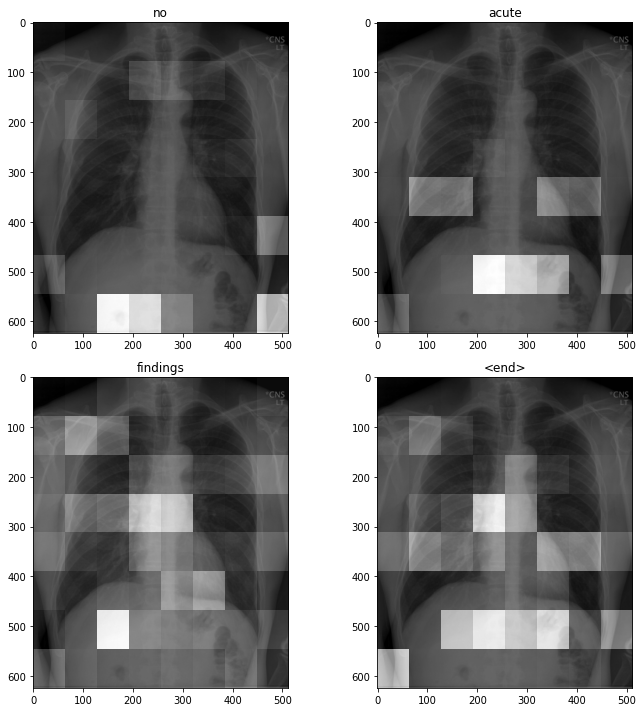

In [0]:
# captions on the validation set
image=img_name_test[646]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: 1735    <start> Moderately hyperinflated lung , otherw...
Name: impressions, dtype: object
Prediction Caption: no acute cardiopulmonary abnormality <end>


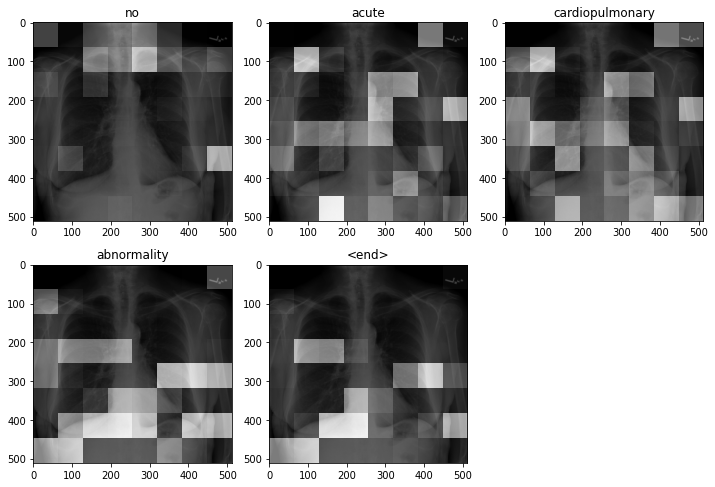

In [0]:
# captions on the validation set
image=img_name_test[1735]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Bad Outputs

Real Caption: 631    <start> Apparent scarring within the lingula, otherwise unremarkable. <end>
Name: impressions, dtype: object
Prediction Caption: continued veriphy no evidence atelectasis <end>


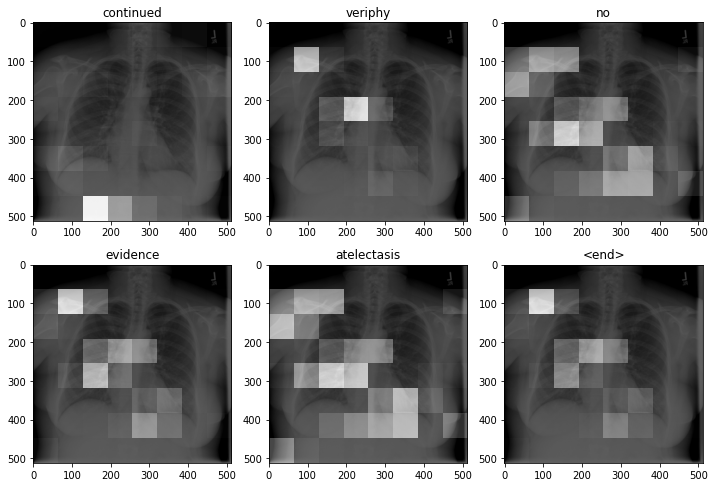

In [0]:
# captions on the validation set
image=img_name_test[631]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


In [0]:
img_name_test[:1]

1218    /content/drive/My Drive/Colab Notebooks/Medical data case study/CXR3192_IM-1505-1001.png
Name: image_names, dtype: object

Real Caption: 1218    <start>  Increased left hilar fullness. This may represent superimposed , adenopathy cannot be excluded on this exam. If there is clinical concern, suggest reference to prior exam or CT chest.  Large hiatal hernia, increased in size from prior exam. <end>
Name: impressions, dtype: object
Prediction Caption: stable elevation apex consolidation or mid change with mild be midlung no disease no process lobe process the opacity <end>


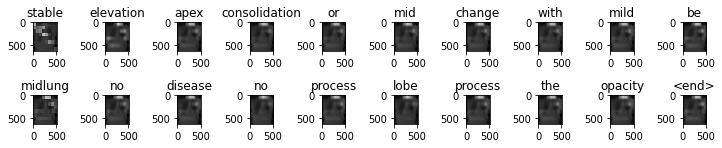

In [0]:
# captions on the validation set
image=img_name_test[1218]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


In [0]:
print('indices to analyse: ', test_error_bad)

indices to analyse:  [0, 6, 99, 108, 124, 138, 140, 144, 169, 222, 239, 264, 268, 300, 325, 329]


In [0]:
img_name_test[264:265]

599    /content/drive/My Drive/Colab Notebooks/Medical data case study/CXR729_IM-2288-1001.png
Name: image_names, dtype: object

Real Caption: 599    <start>  No acute cardiopulmonary abnormality.  .7 cm nodular opacity within the right hilum, there is  large lymph node or partially calcified granuloma. Followup  radiograph to assess stability may be of benefit. <end>
Name: impressions, dtype: object
Prediction Caption: density acute abnormality <end>


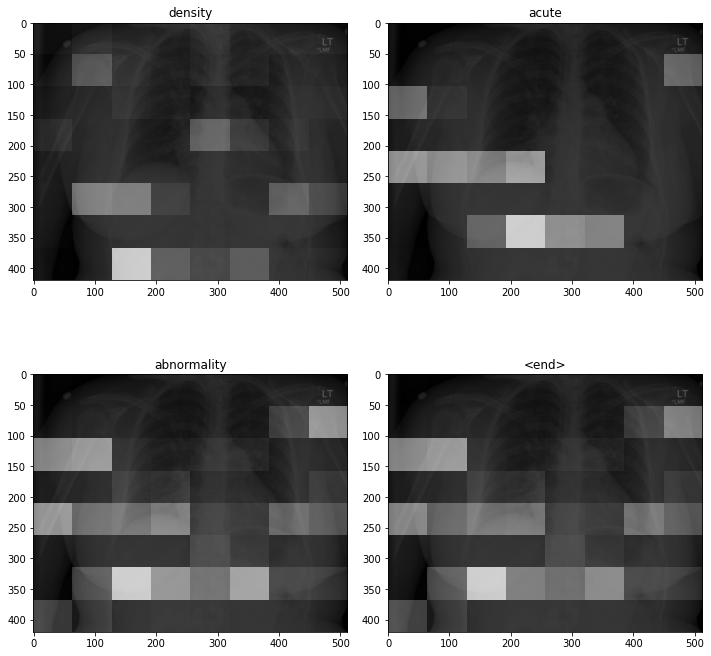

In [0]:
# captions on the validation set
image=img_name_test[599]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: 1447    <start> There is no evidence of acute cardiopu...
Name: impressions, dtype: object
Prediction Caption: no acute cardiopulmonary abnormality <end>
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)
shape attention plot[l]=  (114, 252)


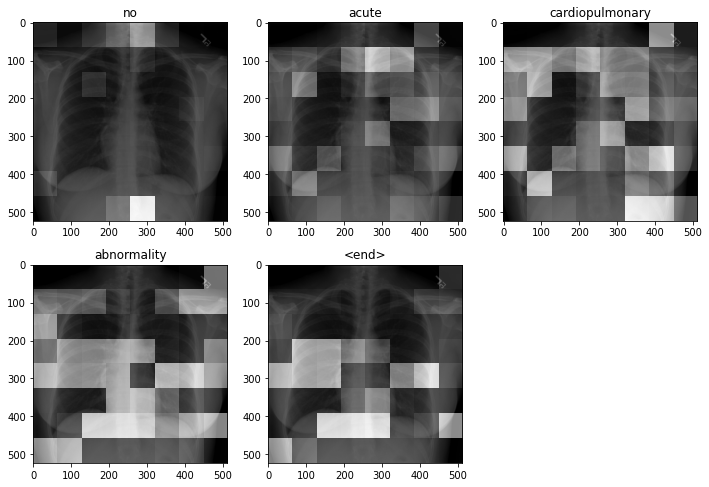

In [0]:
# captions on the validation set
image=img_name_test[1447]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: 2279    <start>  Chronic appearing bibasilar pleural abnormality with possible small effusions.  No evidence of pneumonia. TIPS shunt visualized. . <end>
Name: impressions, dtype: object
Prediction Caption: no abnormality acute cardiopulmonary cardiopulmonary findings <end>


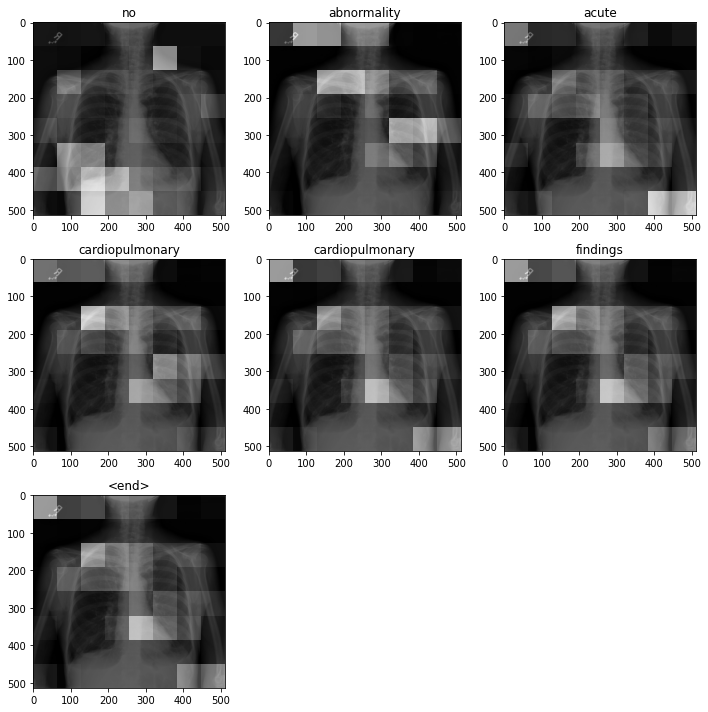

In [0]:
# captions on the validation set
image=img_name_test[2279]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: 1735    <start> Moderately hyperinflated lung , otherwise no acute cardiopulmonary abnormality. <end>
Name: impressions, dtype: object
Prediction Caption: right upper be of findings may focus process suggestive radiograph bilateral changes of cardiopulmonary abnormality <end>


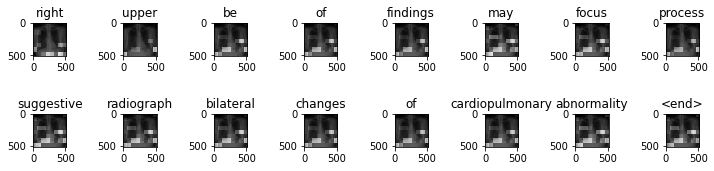

In [0]:
# captions on the validation set
image=img_name_test[1735]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


In [0]:
img_name_test[325:326]

454    /content/drive/My Drive/Colab Notebooks/Medical data case study/CXR576_IM-2174-1001.png
Name: image_names, dtype: object

In [0]:
# captions on the validation set
image=img_name_test[454]
a=df[df['image_names']==image]
# rid = np.random.randint(0, len(img_name_test))   #from live session code on URL Shortner
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption=a['impressions']
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


# Conclusions on Errors

## The model performs well in following cases:
1. No problem or disease found
2. No problem and short outputs sentences
3. The model performs okayish in finding abnormalities relates to Effusion, opacity etc

## The performs bad in following cases:
1. Finding Diseases and clearly pointing out diseases like Pneumonia or any  [effusions](https://www.webmd.com/heart-disease/guide/pericardial-effusion)
2. The model performs bad in case of longer sentences
3. The model performs bad in inflated lungs


## Overall Conclusions
1. The model seems to work fine when everything is normal
2. The outputs needs to be relooked by experts in case of doubts
3. Though this is a good start, but to make this work in a real world scenario to conclude from X-Ray Images, more number of Images with captions needs to be connected

### Taking images online


In [0]:
from IPython.display import Image
from IPython.core.display import HTML
image_url='https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/X-ray_of_COPD_exacerbation_-_anteroposterior_view.jpg/300px-X-ray_of_COPD_exacerbation_-_anteroposterior_view.jpg'
print("Original Image")
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/X-ray_of_COPD_exacerbation_-_anteroposterior_view.jpg/300px-X-ray_of_COPD_exacerbation_-_anteroposterior_view.jpg')

Original Image


24576/17303 [==========================================] - 0s 0us/step
Prediction Caption: normal chest most considerations and osteoporosis could the right left lower lobe evolving findings <end>


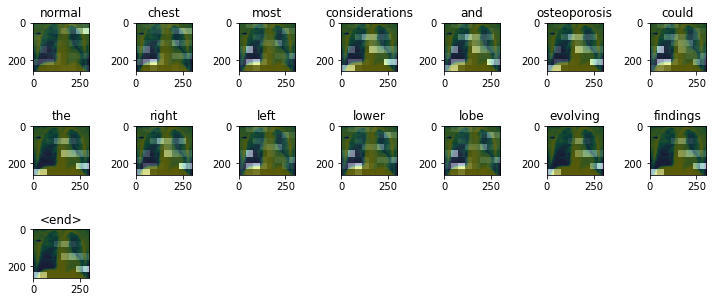

In [0]:
image_url='https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Chest_radiograph_in_influensa_and_H_influenzae%2C_posteroanterior%2C_annotated.jpg/300px-Chest_radiograph_in_influensa_and_H_influenzae%2C_posteroanterior%2C_annotated.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)


Prediction Caption: normal left confirm lung disease <end>


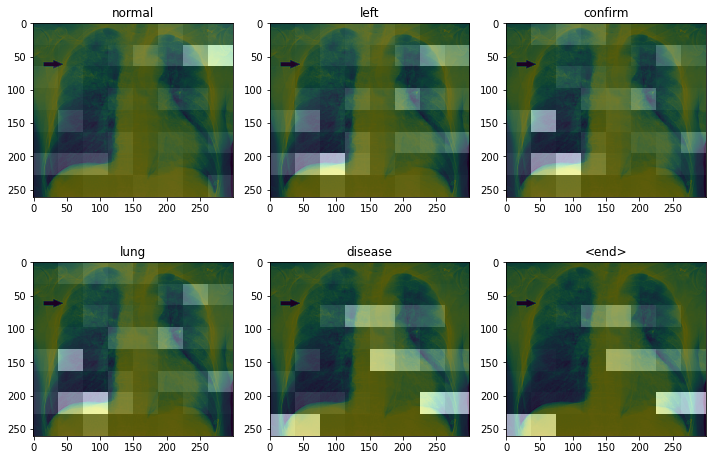

In [0]:
# image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
# Image.open(image_path)